# Qubit compilation of photonic circuits.

We show how to map qubit circuits to post-selected linear optical circuits via the ZX calculus.

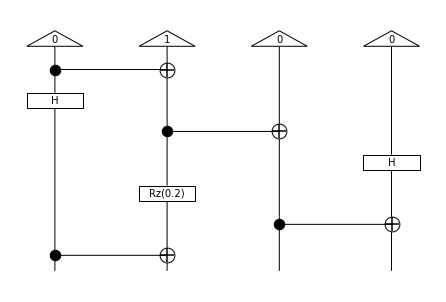

In [1]:
from discopy.quantum import CX, H, Id, Rz, Rx, CZ, Ket

circuit = Ket(0, 1, 0, 0) >> CX @ Id(2) >> H @ CX @ H >> Id(1) @ Rz(0.2) @ CX >> CX @ Id(2)
circuit.draw()

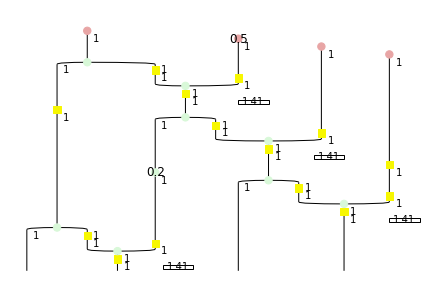

In [2]:
from discopy.quantum.zx import circuit2zx, decomp

diagram = decomp(circuit2zx(circuit))
diagram.draw()

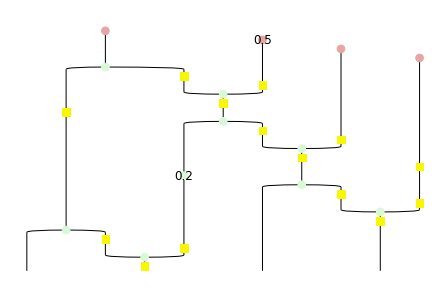

scalar = 4.000000000000001


In [3]:
from discopy.quantum.zx import Scalar

def remove_scalars(d):
    new_diagram = d
    scalar, index = 1, 0
    for i, box in enumerate(d.boxes):
        if isinstance(box, Scalar):
            new_diagram = new_diagram[:i - index] >> new_diagram[i + 1 - index:]
            index += 1
            scalar *= box.data
    return new_diagram, scalar

diagram, scalar = remove_scalars(diagram)
diagram.draw(draw_type_labels=False)
print('scalar = {}'.format(scalar))

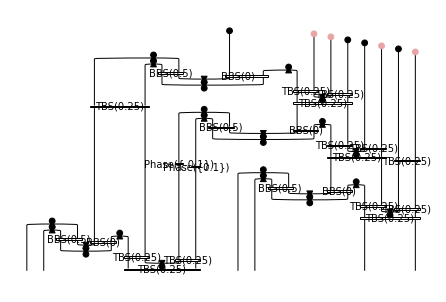

In [4]:
from discopy.quantum.optics import zx2path

circ = zx2path(diagram)
circ.draw(draw_type_labels=False)

In [5]:
def dual_rail_states(n_qubits):
    strings = []
    def genbin(n, bs=[]):
        if len(bs) == 2*n:
            strings.append(bs)
        else:
            genbin(n, bs + [1, 0])
            genbin(n, bs + [0, 1])
    genbin(n_qubits)
    return strings

dual_rail_states(2)

[[1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1]]

Compute amplitudes of the post-selected photonic circuit

In [6]:
from discopy.quantum.optics import evaluate, qpath_drag, to_matrix
import numpy as np

states = dual_rail_states(len(circuit.cod))
array = np.array([evaluate(circ, [], y) for y in states])

Check that the compiled photonic circuit has the same semantics as the qubit circuit we started with, up to a scalar.

In [7]:
assert np.allclose(scalar * array.flatten(), circuit.eval().array.flatten())

Extract unitary photonic circuit and get metrics

In [8]:
from discopy.quantum.optics import qpath_drag, make_square, Id, annil, create

bot, top, mid = qpath_drag(make_square(circ))
print('Number of modes: {}'.format(len(mid.dom)))
print('Number of input photons: {}'.format(bot.boxes.count(create)))
print('Number of post-selected photons: {}'.format(top.boxes.count(annil)))

Number of modes: 32
Number of input photons: 16
Number of post-selected photons: 12


In [9]:
assert np.allclose((mid >> mid.dagger()).array, Id(len(mid.dom)).array)